# Fuzzy obstacle avoidance controller 

In this notebook, we will use an ultra simple Jupyter notebook 2D robot simulator. The robot is assumed to be a differential drive robot with a number of distance sensors to detect obstacles. The world is rectangular and all obstacles are represented by lines.

In the notebook, you can control and animate the robot as it navigates around the world.

For a quick start, run the code cells until you reach [Hello robot](#hello-cell)

**Important**: You may have to install [ffmpeg](https://ffmpeg.org/). If on Windows and Mac, make sure to set the PATH to point at the ´´bin´´ directory of the ffmpeg installation. For Windows, see for instance, [How to Install FFmpeg on Windows?](https://www.geeksforgeeks.org/how-to-install-ffmpeg-on-windows/). For other OS'es, see [How to Install FFmpeg on Linux, macOS, and Windows](https://www.hostinger.com/tutorials/how-to-install-ffmpeg).

In [11]:
! pip install numpy matplotlib scikit-fuzzy
! pip install ffmpeg-python

## Imports

In [12]:
import math
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import animation
from IPython import display

# Simple utility function to rotate a point in 2D
def rotate2d(x, y, theta):
  c = np.cos(theta)
  s = np.sin(theta)
  P = np.array([[c,-s], [s, c]])@[x, y] #rotate by theta
  return P


## The Robot class

An instance of ```Robot``` contains a robot's basic properties:

* Pose in the world frame given as ```x, y, theta``` ($\theta$)
* The speed of the robot's left wheel and right wheel
* The robot's width/physical size and color (color is only used for visualization and has no impact on behavior)
* Number of sensors and their orientations
* The robot's path

A robot can do four things:
* Move using differential drive kinematics
* Compute its sensor readings
* Die if it collides with an obstacle
* Draw/update its graphical representation

Controllers will mainly use ```get_sensor_readings```and ```set_speed``` to control a robots. Performance data can be collected through ```get_pose```and ```is_alive```.


### Sensors

The robot has a number of distance sensors. Each sensor reading is a ```float``` in the interval $[0,$ ```sensor_range```$]$, which corresponds to the distance to the nearest obstacle (if any). If the sensor does not detect anything, its reading will be ```sensor_range```. Sensor readings are computed using ray casting.



In [13]:
class Robot:
  def __init__(self, x, y, theta, color='red'):
    self.x, self.y, self.theta = x, y, theta
    self.color, self.width = color, 1
    self.left_speed, self.right_speed = 0, 0
    self.alive = True
    self.path_x, self.path_y = [x], [y]

    # Configure the number of sensors and their orientation.
    self.sensors = [math.pi / 2, math.pi / 4.0, 0.0, -math.pi / 4.0, -math.pi / 2]
    self.sensor_range = 5

  def compute_line_coordinates(self):
    """
    Used to draw the robot, its sensors and path using matplotlib
    """
    P = np.array([[-1,1,0,-1], [-1,-1, 2,-1]]) # triangle
    c = np.cos(self.theta - np.pi / 2)
    s = np.sin(self.theta - np.pi / 2)
    P = np.array([[c,-s], [s, c]])@P # rotate by theta
      
    x_coords = P[0,:] + self.x #scale and shift to x
    y_coords = P[1,:] + self.y
    
    for sensor in self.sensors:
      x, y = rotate2d(self.sensor_range, 0, sensor + self.theta)
      x_coords = np.append(x_coords, [self.x, self.x + x])
      y_coords = np.append(y_coords, [self.y, self.y + y]) 

    self.path_x.append(self.x)
    self.path_y.append(self.y)
    
    x_coords = np.append(self.path_x, x_coords)
    y_coords = np.append(self.path_y, y_coords) 

    return (x_coords, y_coords)

  def set_pose(self, x, y, theta):
    self.x = x
    self.y = y
    self.theta = theta

  def get_pose(self):
    return self.x, self.y, self.theta

  def draw(self, ax, linewidth=.5, **kwargs):
    self.robot_lines = ax.plot(*self.compute_line_coordinates(), 
                       color=self.color, linewidth=linewidth, **kwargs)
    return self.robot_lines

  def set_speed(self, left, right):
    self.left_speed = left
    self.right_speed = right

  def get_sensor_readings(self): 
    readings = []
    for sensor in self.sensors:
      x, y = rotate2d(self.sensor_range, 0, sensor + self.theta)
      reading = raycast_dist_to_obstacles(self.x, self.y,
                                          self.x + x, self.y + y)      
      reading = min(self.sensor_range, reading)
      readings.append(reading)

    return readings

  def step(self):
    """
    Move the robot forward one simulation step using 2D diff drive kinematics
    """
    if self.alive:
      self.x += (self.left_speed + self.right_speed)/2 * math.cos(self.theta) * 0.1
      self.y += (self.left_speed + self.right_speed)/2 * math.sin(self.theta) * 0.1
      self.theta += (self.right_speed - self.left_speed) / self.width * 0.1

    if raycast_dist_to_obstacles(self.x - self.width, self.y - self.width, 
                                 self.x + self.width, self.y + self.width) < \
                                 2 * self.width or \
       raycast_dist_to_obstacles(self.x - self.width, self.y + self.width,
                                 self.x + self.width, self.y - self.width) < \
                                 2 *self.width:
       self.alive = False
       self.robot_lines[0].set_color('black')
  
  def is_alive(self):
    return self.alive

## Globals, obstacles, and utility functions

See examples further below on how to use the functions

In [14]:
# World globals:
world_width  = 50
world_height = 50
obstacles = [] 

def add_line_segment_obstacle(x1, y1, x2, y2):
  obstacles.append([[x1,y1], [x2,y2]])

def add_rectangular_obstacle(x1, y1, x2, y2):
  add_line_segment_obstacle(x1, y1, x2, y1)
  add_line_segment_obstacle(x2, y1, x2, y2)
  add_line_segment_obstacle(x2, y2, x1, y2)
  add_line_segment_obstacle(x1, y2, x1, y1)

def init_world(width, height):
  global obstacles, world_width, world_height
  
  world_width = width
  world_height = height
  obstacles = []
  add_rectangular_obstacle(0, 0., world_width, world_height)

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

def raycast_dist_to_obstacles(x1, y1, x2, y2):
  """
  Returns the distance from (x1, y1) to the closest obstacle that intersects 
  with the line segment (x1, y1) (x2, y2)
  """
  closest = float("inf")
  for obstacle_segment in obstacles:
    inter = intersect((x1, y1), (x2, y2), obstacle_segment[0], obstacle_segment[1])
    if inter:
      dist = math.sqrt((inter[0] - x1)**2 + (inter[1] - y1)**2)
      if dist < closest:
        closest = dist

  return closest



## Graphics and experiments

See examples further below on how to use the functions

In [15]:
def draw_obstacles(ax, color='red', linewidth=1, **kwargs):    
    for obstacle in obstacles:
        l = mlines.Line2D([obstacle[0][0], obstacle[1][0]], 
                           [obstacle[0][1], obstacle[1][1]])
        ax.add_line(l)

def run_experiment(robot, controller, frames=100, animate=True):
  plot_fig = plt.figure(figsize=(10, 10), dpi=80)
  plot_axes = plt.axes(xlim=(-1, world_width + 1), ylim=(-1, world_height  + 1))
  plt.grid()
  l1 = draw_obstacles(plot_axes)
  robot_lines, = robot.draw(plot_axes)

  def animate_func(frame):
    controller(robot, frame)
    robot.step()
    robot_lines.set_data(*robot.compute_line_coordinates())
    return [robot_lines] #return everything that must be updated

  if animate:
    print("Creating animation of {} frames".format(frames))
    anim = animation.FuncAnimation(plot_fig, animate_func,
                                   frames=frames, interval=20, blit=True)

    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
  else:
    for frame in range(0, frames):
      controller(robot, frame)
      robot.step()
      robot_lines.set_data(*robot.compute_line_coordinates())
    plot_fig.show()
    



<a name="hello-cell"></a>

# Hello robot

Let's start with a simple example where we have a robot circling around an empty world. Aside from the robot itself, its distance sensors and its path are also drawn.

In [16]:
# Init a new world with a width and height of 50
init_world(50, 50)

# Create a new robot with initial location (25, 45) and theta = 0
robot = Robot(25, 45, 0.0)

# Define a controller function that is called at every simulation step to define
# the behavior of the robot. Since we want the robot to describe a circle, we
# set the right speed to be a little less than the left speed:
def circle_controller(robot, frame):
  robot.set_speed(5, 4.75)

# Simulate the robot in the world, use circle_controller to control the robot, 
# run it for 250 frames producing an animation (may take a little bit of time)
run_experiment(robot=robot, controller=circle_controller, frames=250, animate=True)


Creating animation of 250 frames


### Running an experiment without generating an animation

It can take a while to create an animation, so we can also just choose to get the result of an experiment drawn:

/tmp/ipykernel_91738/4279739140.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_fig.show()


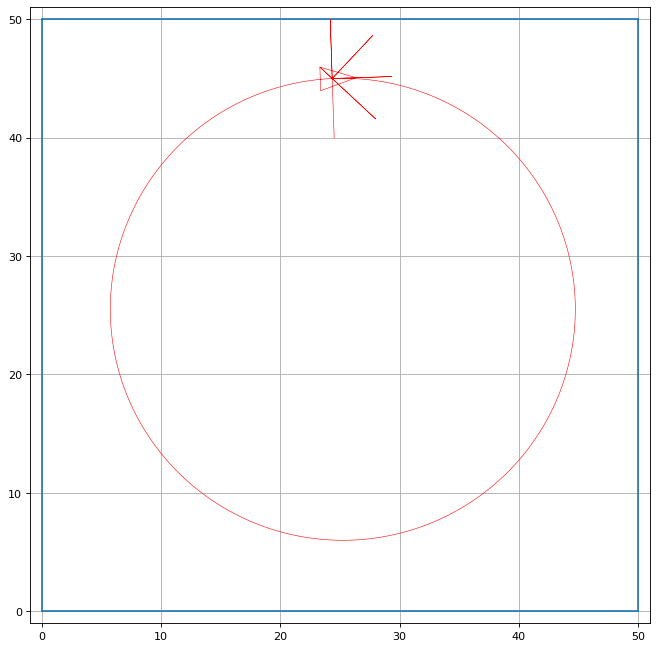

In [17]:
init_world(50, 50)
robot = Robot(25, 45, 0.0)

def circle_controller(robot, frame):
  robot.set_speed(5, 4.75)

# Same as above, but now without animating the simulation (just show the result)
run_experiment(robot=robot, controller=circle_controller, frames=250, animate=False)

## Obstacles and sensors

We can also add obstacles and have the robot respond to them.

In [18]:
init_world(50, 50)

robot = Robot(5, 5, 0.5)
# Add two rectangular obstacles:
add_rectangular_obstacle(10, 1, 40, 15)
add_rectangular_obstacle(1, 30, 49, 40)

# We define the robot's behavior
def simple_obstacle_avoidance(robot, frame):
  readings = robot.get_sensor_readings()
  # if there is something on the left, turn right
  if readings[1] < 4.5:
    robot.set_speed(1.5, -2)
  
  # if there is something on the right, turn left
  elif readings[-2] < 4.5:
    robot.set_speed(-2, 1.5)

  # otherwise, go (almost) straight
  else:  
    robot.set_speed(4, 3.98)

run_experiment(robot=robot, controller=simple_obstacle_avoidance, frames=250, animate=True)


Creating animation of 250 frames


# Exercise


Develop a fuzzy logic controller for a robot that enables the robot to avoid obstacles while navigating to a predefined destination given either by a point or a region in the world. The robot's relative orientation with respect to the predefined destination should be made available to the controller and your control logic must take that information into account, e.g. make the controller go towards the destination if no obstacle is detected.

You must define a rule-base, linguistic variables, linguistic values, and membership functions. 

While your controller does not need to be perfect and capable of handling every situation that the robot may encounter, you should test your solution(s) well and explain when it works/fails and why. You should therefore run multiple experiments with different configurations of obstacles, and you should consider collecting performance statistics.

You are welcome to make reasonable changes and additions to the ```Robot``` class and the utility functions. Adding sensors to the robot or changing the sensor range is, for instance, reasonable, but enabling God mode by making the robot invulnerable to obstacles is **not**, of course. 

/home/valdemar/GitHub/Sem5/AI/venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


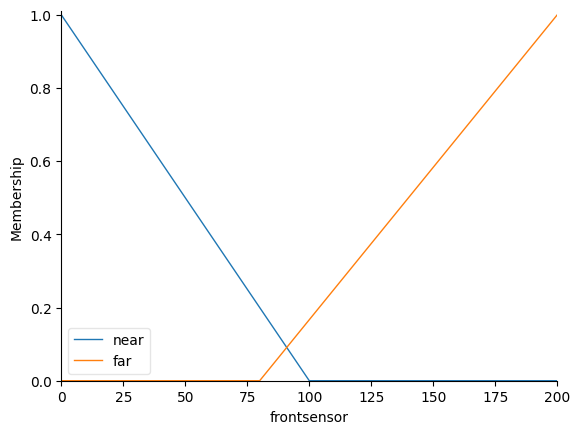

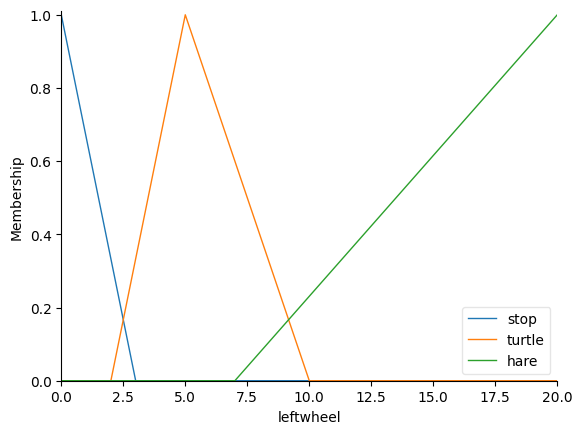

In [19]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# TODO: Implement your controller here
# # ...
# frontsensor  = ctrl.Antecedent(np.arange(0, 201, 1), 'frontsensor')
# leftsensor = ctrl.Antecedent(np.arange(0, 201, 1), 'leftsensor')
# rightsensor = ctrl.Antecedent(np.arange(0, 201, 1), 'rightsensor')
# direction = ctrl.Antecedent(np.arange(0, ))


# leftwheel = ctrl.Consequent(np.arange(0, 21, 1), 'leftwheel')
# rightwheel = ctrl.Consequent(np.arange(0, 21, 1), 'rightwheel')


# ## Membership functions for error
# frontsensor['near'] = fuzz.trimf(frontsensor.universe, [0, 0, 100])
# frontsensor['far'] = fuzz.trimf(frontsensor.universe, [80, 200, 200])

# leftsensor['near'] = fuzz.trimf(leftsensor.universe, [0, 0, 60])
# leftsensor['far'] = fuzz.trimf(leftsensor.universe, [40, 200, 200])

# rightsensor['near'] = fuzz.trimf(rightsensor.universe, [0, 0, 60])
# rightsensor['far'] = fuzz.trimf(rightsensor.universe, [40, 200, 200])


# ## For Valve
# leftwheel['stop'] = fuzz.trimf(leftwheel.universe, [0, 0, 3])
# leftwheel['turtle'] = fuzz.trimf(leftwheel.universe, [2, 5, 10])
# leftwheel['hare'] = fuzz.trimf(leftwheel.universe, [7, 20, 20])

# rightwheel['stop'] = fuzz.trimf(rightwheel.universe, [0, 0, 3])
# rightwheel['turtle'] = fuzz.trimf(rightwheel.universe, [2, 5, 10])
# rightwheel['hare'] = fuzz.trimf(rightwheel.universe, [7, 20, 20])

# frontsensor.view()
# leftwheel.view()

# Rules

In [ ]:

#rule1 = ctrl.Rule(frontsensor['near'] & leftsensor['far'], leftwheel['hare'] & rightwheel['stop'])


# FORSØG nr 2

In [65]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl


# TODO: Implement your controller here
# ...
dist  = ctrl.Antecedent(np.arange(0, 201, 1), 'dist')
sensors = ctrl.Antecedent(np.arange(-90, 91, 1), 'sensors')

direction = ctrl.Consequent(np.arange(0, 21, 1), 'direction')

## Membership functions for error
dist['near'] = fuzz.trimf(dist.universe, [0, 0, 100])
dist['far'] = fuzz.trimf(dist.universe, [80, 200, 200])


## For Valve
direction['left'] = fuzz.trimf(direction.universe, [0, 0, 10])
direction['forward'] = fuzz.trimf(direction.universe, [5, 10, 15])
direction['right'] = fuzz.trimf(direction.universe, [10, 20, 20])

sensors['left'] = fuzz.trimf(sensors.universe, [-90, -90, 0])
sensors['forward'] = fuzz.trimf(sensors.universe, [-30, 0, 30])
sensors['right'] = fuzz.trimf(sensors.universe, [0, 90, 90])



#dist.view()
#direction.view()

# make ROBOT

In [78]:
# Init a new world with a width and height of 50
init_world(50, 50)

# Create a new robot with initial location (25, 45) and theta = 0
my_robot = Robot(5, 4, 180.0)


add_rectangular_obstacle(10, 1, 40, 15)
add_rectangular_obstacle(1, 30, 49, 40)


def closest_obstacle(robot):
    readings = robot.get_sensor_readings()
    print(readings)

    minIndex = readings.index(min(readings))

    return (-robot.sensors[minIndex]) * (180/math.pi)


    


# RULES

In [66]:
rule1 = ctrl.Rule(dist['far'], direction['forward'])
rule2 = ctrl.Rule(dist['near'] & sensors['right'], direction['left'])



# Control system og sim

In [71]:
robot_ctrl = ctrl.ControlSystem([rule1, rule2])
robot_sim = ctrl.ControlSystemSimulation(robot_ctrl)

robot_sim.input['sensors'] = closest_obstacle(my_robot)
robot_sim.input['dist'] = min(my_robot.get_sensor_readings())


[5, 4.0417282796345555, 4.99280639117679, 5, 5]


Creating animation of 50 frames
[2.281914272576575, 5, 5, 5, 5]


KeyError: Consequent: direction

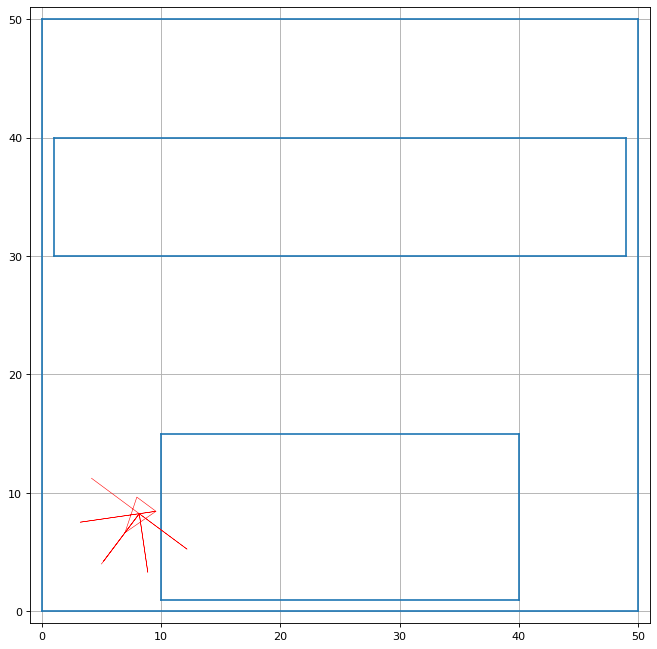

In [80]:
# We define the robot's behavior
def my_obstacle_avoidance(robot, frame):
    #my_robot.set_speed(1,1)        
    robot_sim.input['sensors'] = closest_obstacle(my_robot)
    robot_sim.input['dist'] = min(my_robot.get_sensor_readings())

#    my_robot.set_speed(-1,-1)
    # Crunch the numbers
    robot_sim.compute()

    if robot_sim.output[direction] == 10:
        my_robot.set_speed(10,2)
  

run_experiment(robot=my_robot, controller=my_obstacle_avoidance, frames=50, animate=True)
